# Investigating K-fold Cross Validation

# TOC
___
[Sect.1: Introduction](#Sect.1)

[Sect.2: Linear Regression Model](#Sect.2)

[Sect.3: Linear Regression Model on Census Data ](#Sect.3)

[Sect.4: K-fold Cross Validation](#Sect.4)

[Sect.5: Comparison with Leave One Out Validation](#Sect.5)

# Sect.1
# Introduction
[Back to top](#TOC)

# Sect.2
# Linear Regression Model
[Back to top](#TOC)

In this section we will:
- Import Census population data
- Set up methods to create a linear regression model based on training data inputted with expected target values

In [1]:
#Import
import pandas as pd
import numpy as np
import seaborn as sns
import random

### Least squares estimator

$$y = \beta X + \epsilon $$

Least Squares Estimator (Best Linear Unbiased Estimator) of model parameters (Wasserman p217):

$$ \hat{\beta} = (X'X)^{-1}(X'Y)$$

In [2]:
def linear_regression(x_train, y_train):
    '''
    input: x_train (arraylike, size: n x p)
            y_train (arraylike, size: n x 1)
            
    Uses the least squares estimator to create a model (b_hat) which is returned 
    
    output: b_hat (arraylike, size p x 1)
    '''
    x_prime = x_train.T
    
    # TEST
    print("X train: \n", x_train)
    print(" Y train: \n", y_train)
    print("x_prime: \n", x_prime)
    
    # Calculate the Least Squares Estimates of model coefficients
    # B_hat = ( X'X)^-1 X'Y
    first_term = np.linalg.inv( np.matmul(x_prime, x_train) )
    second_term = np.matmul(first_term , x_prime)
    B_hat = np.matmul( second_term ,  y_train)
    
    return B_hat

To test the linear regression model, we will use a linear dataset and try to find the original parameters of the generating model:

### Make dataset to test lin reg

In [3]:
def prepare_inputs(y_train, *x_trains):
    '''
    Takies in np.arrays y_train, and 1+ x_trains 
    
    It checks if the y_train and x_train are the same length
    
    then it transposes the y_train and 
    '''
    first_col = x_trains[0]
    for col in x_trains:
        assert(len(first_col) == len(col))
    
    # Join x_train columns
    input_vars = np.array(x_trains)
    
    # Transpose
    input_vars = np.transpose(input_vars)
    
    # Add extra column of ones
    ones_col = np.transpose(np.matrix(np.ones(first_col.shape[0])))
    input_vars = np.append(ones_col,input_vars,  axis=1)
    
    # Transpose y train
    y_train = np.transpose(np.matrix(y_train))
    
    return input_vars, y_train

 

In [4]:
# Suppose we have a generating function which takes 2 input variables (x,z) to 
# to make a target variable y:
# y =  3x + 2z + 5 + E (noise)

x = np.array([1,5,6,3,2]) #+ np.array([np.random.normal() for _ in range(len(x))])
z =  np.array([2,5,3,11,6]) 
y = 3*x + 2*z + 5 + np.array([np.random.normal() for _ in range(len(x))])

input_vars, y_train= prepare_inputs(y, x, z )

input_vars, y_train

(matrix([[ 1.,  1.,  2.],
         [ 1.,  5.,  5.],
         [ 1.,  6.,  3.],
         [ 1.,  3., 11.],
         [ 1.,  2.,  6.]]),
 matrix([[10.79969744],
         [31.89147757],
         [28.84526891],
         [35.06000587],
         [23.44639322]]))

### Create Lin Reg Model

In [5]:
B_hat = linear_regression(input_vars, y_train)

print(f"Estimate of model parameters (B_hat):\n {B_hat}")

X train: 
 [[ 1.  1.  2.]
 [ 1.  5.  5.]
 [ 1.  6.  3.]
 [ 1.  3. 11.]
 [ 1.  2.  6.]]
 Y train: 
 [[10.79969744]
 [31.89147757]
 [28.84526891]
 [35.06000587]
 [23.44639322]]
x_prime: 
 [[ 1.  1.  1.  1.  1.]
 [ 1.  5.  6.  3.  2.]
 [ 2.  5.  3. 11.  6.]]
Estimate of model parameters (B_hat):
 [[4.0577388 ]
 [3.30396981]
 [1.98469119]]


### Predict using Lin Reg Model

In [6]:
def predict(model, x_pred):
    '''
    input: model (arraylike, size: p x 1)
            x_pred (arraylike, size m x p)
            
    Uses the least squares estimator model (b_hat) from the linear_regression function to 
    make a prediction for what the output set (y_pred) would be given a certain input set (x_pred)
    
    [y_pred] = [x_pred] * [b_hat] 
    asserts that the num. columns in x_pred = the rows of the model (p)
    
    output: y_pred (arraylike, size m x 1)
    '''
    print("Model shape: ", model.shape)
    print("Input shape: " , x_pred.shape)
    assert(model.shape[0] == x_pred.shape[1])
    y_pred = np.matmul(x_pred, model)
    
    return np.matrix(y_pred)

In [7]:
# Test what model predicts for new inputs:
x_pred = np.array([1,2,3,6,4,7]) #+ np.array([np.random.normal() for _ in range(len(x))])
z_pred =  np.array([5,6,7,8,9,10]) 
y_pred = 3*x_pred + 2*z_pred + 5 + np.array([np.random.normal() for _ in range(len(x_pred))])

input_vars, y_train= prepare_inputs(y_pred, x_pred, z_pred)

input_vars, y_train

(matrix([[ 1.,  1.,  5.],
         [ 1.,  2.,  6.],
         [ 1.,  3.,  7.],
         [ 1.,  6.,  8.],
         [ 1.,  4.,  9.],
         [ 1.,  7., 10.]]),
 matrix([[17.18764715],
         [24.88314167],
         [28.39852153],
         [38.21407831],
         [34.08452301],
         [44.8706975 ]]))

In [8]:
# Try to preditct:
y_prediction = predict(B_hat , input_vars)
y_prediction_matrix = zip(y_prediction, y_train)

print(f"predicted\t actual \t\t diff")
MSE = 0
for y_p , y_t in y_prediction_matrix:
    error = y_p[0] -y_t[0]
    MSE +=  error**2
    print(f"{y_p[0]}\t{y_t[0]}\t{error}")

print("MSE is :", MSE/len(y_prediction))

Model shape:  (3, 1)
Input shape:  (6, 3)
predicted	 actual 		 diff
[[17.28516458]]	[[17.18764715]]	[[0.09751743]]
[[22.57382558]]	[[24.88314167]]	[[-2.30931608]]
[[27.86248659]]	[[28.39852153]]	[[-0.53603495]]
[[39.75908721]]	[[38.21407831]]	[[1.5450089]]
[[35.13583878]]	[[34.08452301]]	[[1.05131578]]
[[47.03243941]]	[[44.8706975]]	[[2.16174191]]
MSE is : [[2.29920489]]


### Calculating MSPE of prediction

In [9]:
def MSPE(y_predicted, y_train):
    '''
    Mean Square Predictiona error:
    
    input: y_predicted (arraylike, size: m x 1)
           y (arraylike, size m x 1)
            
    Finds the sum of squared differences between the predicted y values in the training set
    and the observed y_train values
    '''
  
    assert(len(y_predicted) == len(y_train))
    
    errors = np.subtract(y_predicted , y_train)
    
    print("Y pred:\n", y_predicted)
    print("Y train:\n", y_train)
    
    # MSPE = (predicted - actual)**2 / n
    mean_error = np.matmul( errors.T, errors) / len(y_train)
    print("Mean squared errors: ", mean_error)
    
    '''
    #print side by side - BETTER
    print(f"predicted\t actual \t\t diff")
    MSE = 0
    for y_p , y_t in y_prediction_matrix:
        error = y_p[0] -y_t[0]
        MSE +=  error**2
        print(f"{y_p[0]}\t{y_t[0]}\t{error}")

    print("MSE is :", MSE/len(y_prediction))
    '''
    
    return errors,mean_error[0,0]

In [10]:
# Find MSPE of the estimates:

MSPE_errors, error = MSPE(y_prediction, y_train )
print("Mean Squared Prediction Error: ", error)
MSPE_errors, error

Y pred:
 [[17.28516458]
 [22.57382558]
 [27.86248659]
 [39.75908721]
 [35.13583878]
 [47.03243941]]
Y train:
 [[17.18764715]
 [24.88314167]
 [28.39852153]
 [38.21407831]
 [34.08452301]
 [44.8706975 ]]
Mean squared errors:  [[2.29920489]]
Mean Squared Prediction Error:  2.299204886975913


(matrix([[ 0.09751743],
         [-2.30931608],
         [-0.53603495],
         [ 1.5450089 ],
         [ 1.05131578],
         [ 2.16174191]]),
 2.299204886975913)

# Sect.3
# Linear Regression Model on Census Data

Taking the census data from 2010, we wi

Census Dataset:
For the years of 2010 to 2015 they have the following data for each county:
- Births
- Deaths
- Net migration
- NATURALINC2010  = Births - deaths

[Back to top](#TOC)

In [11]:
# Import Census data from CSV
census = pd.read_csv("census.csv")
census.describe()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015
count,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3.193000e+03,3.193000e+03,3.193000e+03,3.193000e+03,3.193000e+03,...,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000,3193.000000
mean,49.840276,2.668650,5.191356,30.259004,101.918572,1.933871e+05,1.933969e+05,1.937657e+05,1.952514e+05,1.967445e+05,...,-1.639167,-2.528381,-1.288083,-2.271925,-1.362607,-0.655205,-1.445775,-0.200419,-1.038960,-0.096759
std,1.253884,0.807513,1.973991,15.153897,107.626583,1.176201e+06,1.176244e+06,1.178710e+06,1.189648e+06,1.200508e+06,...,10.407267,11.871798,12.186844,11.440505,12.301558,10.613259,12.228155,12.200064,11.471743,12.265772
min,40.000000,1.000000,1.000000,1.000000,0.000000,8.200000e+01,8.200000e+01,8.300000e+01,9.000000e+01,8.100000e+01,...,-128.205128,-147.727273,-109.876862,-178.947368,-84.844838,-128.205128,-147.727273,-102.988031,-178.947368,-62.322703
25%,50.000000,2.000000,4.000000,18.000000,33.000000,1.129900e+04,1.129900e+04,1.127500e+04,1.127700e+04,1.119500e+04,...,-6.153101,-7.561799,-6.323058,-7.357497,-6.696825,-5.354221,-6.851764,-5.426357,-6.221820,-5.553088
50%,50.000000,3.000000,5.000000,29.000000,77.000000,2.642400e+04,2.644600e+04,2.646700e+04,2.641700e+04,2.636200e+04,...,-1.544618,-2.549859,-1.771445,-1.988101,-2.026566,-0.626174,-1.537988,-0.788296,-0.911948,-0.872527
75%,50.000000,3.000000,7.000000,45.000000,133.000000,7.140400e+04,7.149100e+04,7.172100e+04,7.238700e+04,7.249600e+04,...,2.901204,2.626611,3.392786,3.333927,3.794291,4.062151,3.962629,4.700873,4.580444,5.013928
max,50.000000,4.000000,9.000000,56.000000,840.000000,3.725396e+07,3.725450e+07,3.733408e+07,3.770003e+07,3.805606e+07,...,101.123595,119.193807,239.130435,146.367943,281.407035,101.123595,119.861185,239.130435,146.960126,281.407035


In [12]:
# Select ONLY County level rows

census_counties = census[census["SUMLEV"] == 50]

print("Sum of 2010 census populations by counties: " , sum(census_counties["CENSUS2010POP"]))
census_counties["STNAME"].value_counts().sort_index()
# 51 states - States + DC

Sum of 2010 census populations by counties:  308739316


Alabama                  67
Alaska                   29
Arizona                  15
Arkansas                 75
California               58
Colorado                 64
Connecticut               8
Delaware                  3
District of Columbia      1
Florida                  67
Georgia                 159
Hawaii                    5
Idaho                    44
Illinois                102
Indiana                  92
Iowa                     99
Kansas                  105
Kentucky                120
Louisiana                64
Maine                    16
Maryland                 24
Massachusetts            14
Michigan                 83
Minnesota                87
Mississippi              82
Missouri                115
Montana                  56
Nebraska                 93
Nevada                   17
New Hampshire            10
New Jersey               21
New Mexico               33
New York                 62
North Carolina          100
North Dakota             53
Ohio                

In [13]:
columns10 = [x for x in census.columns if x.endswith("2010")]
columns11 = [x for x in census.columns if x.endswith("2011")]

In [14]:
census_counties.to_clipboard()


In [15]:
# Figuring out how the fields relate
autauga = census_counties.iloc[0]

autauga["CENSUS2010POP"]
print("Name: ", autauga["CTYNAME"])
print(f"~"*50)
print( autauga["CENSUS2010POP"], " = Census 2010 pop ")
print( autauga["BIRTHS2010"], " = Births 2010 pop ")
print( autauga["DEATHS2010"], " = Deaths 2010 pop ")
print( autauga["NETMIG2010"], " = Net Migration 2010 pop ")

print( autauga["NPOPCHG_2010"], " = Pop Change 2010")
autauga.to_clipboard()
autauga[columns10].to_clipboard()


Name:  Autauga County
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
54571  = Census 2010 pop 
151  = Births 2010 pop 
152  = Deaths 2010 pop 
82  = Net Migration 2010 pop 
89  = Pop Change 2010


In [16]:
autauga[columns11].to_clipboard()

In [17]:
input_vars, y_train= prepare_inputs(y_pred, x_pred, z_pred)

input_vars, y_train

(matrix([[ 1.,  1.,  5.],
         [ 1.,  2.,  6.],
         [ 1.,  3.,  7.],
         [ 1.,  6.,  8.],
         [ 1.,  4.,  9.],
         [ 1.,  7., 10.]]),
 matrix([[17.18764715],
         [24.88314167],
         [28.39852153],
         [38.21407831],
         [34.08452301],
         [44.8706975 ]]))

# Sect.3
# Linear Regression Model on Heart Disease Data

Heart Disease Dataset:
- age
- sex
- cp
- trestbps
- chol
- fbs
- restecg
- thalach
- exang
- oldpeak
- slope
- ca
- thal
- target
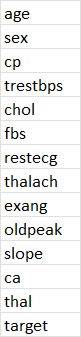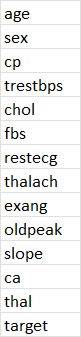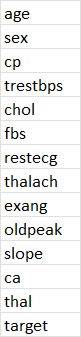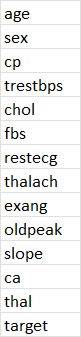

[Back to top](#TOC)

In [18]:
# Import HEART data from CSV
heart = pd.read_csv("heart.csv")
heart.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


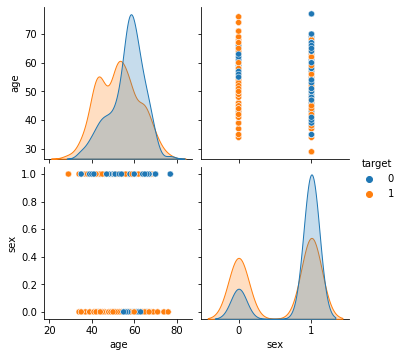

In [19]:
heart_subset = heart[['age','sex','target']]
sns.pairplot(heart_subset, hue = 'target')

In [20]:
# Try to run the linear regression on the heart subset data

heart_X = heart_subset["target"]

heart_Y =heart_subset["target"]


heart_X, heart_Y

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1020    1
 1021    0
 1022    0
 1023    1
 1024    0
 Name: target, Length: 1025, dtype: int64,
 0       0
 1       0
 2       0
 3       0
 4       0
        ..
 1020    1
 1021    0
 1022    0
 1023    1
 1024    0
 Name: target, Length: 1025, dtype: int64)

In [21]:
heart_X =heart.loc [:, heart.columns != "target"]

heart_Y =heart_subset["target"]

heart_X, heart_Y 

(      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
 0      52    1   0       125   212    0        1      168      0      1.0   
 1      53    1   0       140   203    1        0      155      1      3.1   
 2      70    1   0       145   174    0        1      125      1      2.6   
 3      61    1   0       148   203    0        1      161      0      0.0   
 4      62    0   0       138   294    1        1      106      0      1.9   
 ...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
 1020   59    1   1       140   221    0        1      164      1      0.0   
 1021   60    1   0       125   258    0        0      141      1      2.8   
 1022   47    1   0       110   275    0        0      118      1      1.0   
 1023   50    0   0       110   254    0        0      159      0      0.0   
 1024   54    1   0       120   188    0        1      113      0      1.4   
 
       slope  ca  thal  
 0         2   2     3  
 1         0

In [22]:
# RUN LIN REG ON HEART SUBSET

B_hat = linear_regression( heart_X, heart_Y)

print(f"Estimate of model parameters (B_hat):\n {B_hat}")

X train: 
       age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0      52    1   0       125   212    0        1      168      0      1.0   
1      53    1   0       140   203    1        0      155      1      3.1   
2      70    1   0       145   174    0        1      125      1      2.6   
3      61    1   0       148   203    0        1      161      0      0.0   
4      62    0   0       138   294    1        1      106      0      1.9   
...   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
1020   59    1   1       140   221    0        1      164      1      0.0   
1021   60    1   0       125   258    0        0      141      1      2.8   
1022   47    1   0       110   275    0        0      118      1      1.0   
1023   50    0   0       110   254    0        0      159      0      0.0   
1024   54    1   0       120   188    0        1      113      0      1.4   

      slope  ca  thal  
0         2   2     3  
1         0   0 

C:\Users\rsvpr\AppData\Local\Temp\ipykernel_6968\326083202.py:19: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  first_term = np.linalg.inv( np.matmul(x_prime, x_train) )


In [23]:
y_prediction = np.ravel(y_prediction)
for index in range(len(y_prediction)):
    if(y_prediction[index]>=0.5):
        y_prediction[index] = 1
    else:
        y_prediction[index] = 0
    
y_prediction


array([1., 1., 1., 1., 1., 1.])

In [24]:
heart_Y,
# Try to preditct:
y_prediction = predict(B_hat , heart_X)
y_prediction_matrix = zip(y_prediction.T, np.matrix(heart_Y).T)

# Convert to 1 and 0 predictions
y_prediction = np.ravel(y_prediction)
for index in range(len(y_prediction)):
    if(y_prediction[index]>=0.5):
        y_prediction[index] = 1
    else:
        y_prediction[index] = 0
        
        
print(f"predicted\t actual \t\t diff")
MSE = 0
for y_p , y_t in y_prediction_matrix:
    error = y_p[0] -y_t[0]
    MSE +=  error**2
    print(f"{y_p[0]}\tcd{y_t[0]}\t{error}")

MSE= MSE/len(y_prediction.T)
print("MSE is :", MSE)
print("RMSE is :", np.sqrt(MSE))


C:\Users\rsvpr\AppData\Local\Temp\ipykernel_6968\3910148774.py:17: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  y_pred = np.matmul(x_pred, model)


Model shape:  (13,)
Input shape:  (1025, 13)
predicted	 actual 		 diff
[[0.]]	cd[[0]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[0]]	[[1.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[0]]	[[1.]]
[[1.]]	cd[[1]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[1.]]	cd[[0]]	[[1.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[1]]	[[-1.]]
[[1.]]	cd[[1]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[1.]]	cd[[0]]	[[1.]]
[[1.]]	cd[[0]]	[[1.]]
[[0.]]	cd[[0]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[0.]]	cd[[0]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[1.]]	cd[[0]]	[[1.]]
[[0.]]	cd[[1]]	[[-1.]]
[[1.]]	cd[[1]]	[[0.]]
[[0.]]	cd[[1]]	[[-1.]]
[[1.]]	cd[[0]]	[[1.]]
[[1.]]	cd[[1]]	[[0.]]
[[1.]]	cd[[1]]	[[0.]]
[[

In [32]:
MSPE_errors, error = MSPE(np.matrix(y_prediction).T, np.matrix(heart_Y).T )
print("Mean Squared Prediction Error: ", error)
MSPE_errors, error

Y pred:
 [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]
Y train:
 [[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
Mean squared errors:  [[0.15317073]]
Mean Squared Prediction Error:  0.15317073170731707


(matrix([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]),
 0.15317073170731707)

In [26]:
len(np.matrix(heart_Y).T)

len(y_prediction.T)

1025

# Sect.4
#  K-fold Cross Validation
[Back to top](#TOC)

In [27]:
# Borrowed from Dr. Stephyn Butcher, "Fundementals of Data Science," p608
'''
input:
xs (list): list to be divided
n (int) : number of folds


output:
xs split into n sub-lists, each with size within 1 of (floor(len(xs)/n))  
'''
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [28]:
test = pd.DataFrame({"a": range(16)})

indices = list(range(len( test)))

folds = chunk(indices, 5)

folds

[[0, 1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14, 15]]

In [29]:
# Borrowed from Dr. Stephyn Butcher, "Fundementals of Data Science," p608
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

# Sect.5
# Comparison with Leave One Out Validation
[Back to top](#TOC)